# REQUIREMENTS

In [116]:
import wrds, datetime
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

conn = wrds.Connection()

Loading library list...
Done


# DATA COLLECTION

In [117]:
query_start_date = '1990-01-01'

In [118]:
sp500_data = conn.raw_sql(f"""
SELECT
    caldt AS date,
    sprtrn AS daily_return -- Equal-Weighted Return (includes distributions) (ewretd)
FROM
    crspq.dsp500
WHERE
    caldt >= '{query_start_date}'
ORDER BY
    caldt;
""")
sp500_data['date'] = pd.to_datetime(sp500_data['date'])

sp500_data

,date,daily_return
0,1990-01-02,0.017799
1,1990-01-03,-0.002586
2,1990-01-04,-0.008613
3,1990-01-05,-0.009756
4,1990-01-08,0.004514
...,...,...
8748,2024-09-24,0.002511
8749,2024-09-25,-0.001861
8750,2024-09-26,0.004039
8751,2024-09-27,-0.001253


In [120]:
risk_free_data = conn.raw_sql(f'''
    SELECT
        date,
        rf AS daily_rf_rate -- One Month Treasury Bill Rate (daily)
    FROM
        ff.factors_daily
    WHERE
        date >= '{query_start_date}'
''')

risk_free_data['date'] = pd.to_datetime(risk_free_data['date'])

risk_free_data

,date,daily_rf_rate
0,1990-01-02,0.00026
1,1990-01-03,0.00026
2,1990-01-04,0.00026
3,1990-01-05,0.00026
4,1990-01-08,0.00026
...,...,...
8771,2024-10-25,0.00017
8772,2024-10-28,0.00017
8773,2024-10-29,0.00017
8774,2024-10-30,0.00017


# Choosing Companies

In [121]:
# retrieves ID (permno) and earliest recorded name for each company in CRSP database
# 37,776 companies available

comps = conn.raw_sql( '''
SELECT permno, MIN(comnam) AS company_name
FROM crsp.stocknames
GROUP BY permno
''')
comps

,permno,company_name
0,83264,GREIF BROTHERS CORP
1,63618,HINDERLITER ENERGY EQUIP CORP
2,10896,CAMILLE ST MORITZ INC
3,69906,SEIBELS BRUCE GROUP INC
4,79030,GREAT CENTRAL MINES LTD
...,...,...
37771,14886,ARK E T F TRUST
37772,79163,A M F M INC
37773,86036,BRENTWOOD INSTRUMENTS INC
37774,92970,CHINA EDUCATION ALLIANCE INC


In [122]:
#TODO: choose a way to narrow the above list of permnos to <500. Will then use that list with the following functions to gather fin data
#this will go away when the above is completed.

company_search = 'AMAZON' # FIND A COMPANY HERE

comps[comps['company_name'].str.contains(f'{company_search}')]

,permno,company_name
9682,84788,AMAZON COM INC


# Helper functions

In [123]:
def get_comp_data(permno, gvkey):

    company_fin_data = get_company_financials(gvkey)
    
    #forward fill
    company_fin_data = company_fin_data.ffill().dropna()
    company_stock_prcs = get_prices(permno)
    
    # Create new columns with just year and month
    company_fin_data['year_month'] = company_fin_data['date'].dt.strftime('%Y-%m')
    company_stock_prcs['year_month'] = company_stock_prcs['date'].dt.strftime('%Y-%m')
    
    company = pd.merge(company_fin_data, company_stock_prcs, on='year_month')

    company.drop(columns=['year_month', 'date_y'], axis=1, inplace=True)
    company.rename(columns={'date_x':'date'}, inplace=True)
    
    # company = pd.merge(company_fin_data, company_stock_prcs, on='date', how='inner')
    # company['date'] = company['reporting_date'] # backtest logic TODO
    return company

In [124]:
def get_company_financials(gvkey):
    company_fin_data = conn.raw_sql(f'''
    SELECT
        datadate AS date,
        gvkey AS gvkey,
        rdq AS reporting_date, -- Date of which information was reported
        atq AS total_assets,  -- Total Assets
        chq AS cash_holdings,  -- Cash and Short-Term Investments
        dlttq + dlcq AS total_debt,  -- Total Debt (long-term + short-term debt)
        ibq AS earnings,  -- Earnings before extraordinary items
        xrdq AS rd_expense,  -- R&D expense
        dvpq AS dividends_paid,  -- Dividends paid
        xintq AS interest_expense  -- Interest expense
    FROM
        comp.fundq
    WHERE
        gvkey = '{gvkey}'
        AND datadate >= '{query_start_date}'  -- Ensure data is after the link start date
    ''')
    
    company_fin_data['date'] = pd.to_datetime(company_fin_data['date'])
    company_fin_data['reporting_date'] = pd.to_datetime(company_fin_data['reporting_date'])
    
    start_date = company_fin_data['date'].min()
    end_date = company_fin_data['date'].max()
    all_months = pd.date_range(start=start_date, end=end_date, freq='ME')
    full_range_df = pd.DataFrame({'date': all_months})
    company_fin_data = pd.merge(full_range_df, company_fin_data, on='date', how='left')
    
    company_fin_data['month_start'] = company_fin_data['date'] - pd.offsets.MonthBegin()
    company_fin_data['month_end'] = company_fin_data['date']
    
    return company_fin_data

In [125]:
def get_gvkey(permno):
    link = conn.raw_sql(f'''
    SELECT *
    FROM crsp.ccmxpf_linktable
    WHERE lpermno = {permno};
    ''')
    
    return link['gvkey'][0]

In [126]:
def get_prices(permno):
    company_stock_prcs = conn.raw_sql(f'''
    SELECT
        date,
        prc AS stock_price,
        ret AS stock_return,  -- Stock returns from CRSP
        prc * shrout AS market_cap  -- Market cap
    FROM
        crsp.msf
    WHERE
        permno = {permno}
    ''')
    
    company_stock_prcs['date'] = pd.to_datetime(company_stock_prcs['date'])
    
    return company_stock_prcs

In [127]:
#calculations for cash-hedging & returns
def calculate_returns(company, lower = 0.01, upper = 0.99):
    company['cash_share_weight'] = (company['cash_holdings'] / company['total_assets'])
    company['cash_holdings_t_minus_1'] = company['cash_holdings'].shift()
    
    calculate_b_it(company)
    calculate_e_it(company)
    company['cash_hedged_return'] = winsorize(company['cash_hedged_return'], lower, upper)

In [128]:
def calculate_b_it(company):
    data = company.copy()
    data['market_cap_t_minus_1'] = data['market_cap'].shift() # paper uses M_{t-1} for the denoms
    data['leverage'] = data['total_debt'] / (data['total_debt'] + data['market_cap'])
    
    # Y VALUES
    data['r_minus_R'] = data['stock_return'] - data['rf_rate']
    
    # REGRESSION VARIABLES
    data['gamma_1'] = (data['cash_holdings'].diff()) / data['market_cap_t_minus_1']
    data['gamma_2'] = (data['earnings'].diff()) / data['market_cap_t_minus_1']
    data['gamma_3'] = ((data['total_assets'] - data['cash_holdings']).diff()) / data['market_cap_t_minus_1']
    data['gamma_4'] = (data['rd_expense'].diff()) / data['market_cap_t_minus_1']
    data['gamma_5'] = (data['interest_expense'].diff()) / data['market_cap_t_minus_1']
    data['gamma_6'] = (data['dividends_paid'].diff()) / data['market_cap_t_minus_1']
    data['gamma_7']= data['cash_holdings_t_minus_1'] / data['market_cap_t_minus_1']
    data['gamma_8'] = data['leverage']
    data['gamma_9'] = (data['total_debt'].diff() + data['market_cap_t_minus_1'].diff()) / (data['total_debt'].shift() + data['market_cap_t_minus_1'].shift())
    data['gamma_10'] = (data['market_cap_t_minus_1'] * (data['cash_holdings'].diff())) / (data['market_cap'] ** 2)
    data['gamma_11'] = (data['leverage'] * (data['cash_holdings'].diff())) / data['market_cap']
    
    data = data.dropna()
    
    y = data['r_minus_R']
    X = data[['gamma_1', 'gamma_2', 'gamma_3', 'gamma_4', 'gamma_5', 'gamma_6', 'gamma_7', 'gamma_8', 'gamma_9', 'gamma_10', 'gamma_11']]
    
    X = sm.add_constant(X)
    
    model = sm.OLS(y, X).fit()
    
    #print(model.summary())
    
    data['marginal_cash_value'] = (
        model.params.iloc[0] +
        (model.params.iloc[10] * (data['cash_holdings_t_minus_1'] / data['market_cap_t_minus_1'])) +
        (model.params.iloc[11] * data['leverage'])
    )
    
    data['average_cash_value'] = data['marginal_cash_value'] * data['cash_holdings']
    
    company['b_it'] = data['average_cash_value'].pct_change()  # monthly cash return

In [129]:
def calculate_e_it(company):
    company['cash_hedged_return'] = (1 / (1 - company['cash_share_weight'])) * (company['stock_return'] - (company['cash_share_weight']  * company['b_it']))

In [130]:
def winsorize(series, lower=0.01, upper=0.99):
    lower_threshold = series.quantile(lower)
    upper_threshold = series.quantile(upper)
    return series.clip(lower=lower_threshold, upper=upper_threshold)

In [131]:
window = 65 # months

def calculate_rolling_beta(stock_return, market_return, window = 65):
    rolling_cov = stock_return.rolling(window).cov(market_return)
    rolling_var = market_return.rolling(window).var()
    return rolling_cov / rolling_var

# Getting Aggregate & Cleaned Data

In [196]:
#permnos = [10107, 86580, 84788]
# BELOW IS THE LIST OF PERMNOs FOR TEN COMPANIES

query = """
select distinct on (a.permno) a.permno, a.permco, a.cusip, a.comnam 
from crsp.stocknames a
where a.comnam ilike '%%alphabet%%' and a.cusip like '02079K30'
    or a.comnam ilike '%%amazon%%'
    or a.comnam ilike 'apple inc%%'
    or a.comnam ilike '%%meta platforms%%'
    or a.comnam ilike '%%microsoft%%'
    or a.comnam ilike '%%nvidia%%'
    or a.comnam ilike '%%tesla inc%%'
    or a.comnam ilike '%%netflix%%'
    or a.comnam ilike '%%walmart%%'
    or a.comnam ilike '%%pfizer%%'
;
"""

table = conn.raw_sql(query)
permnos = table['permno'].to_list()
print(table)

# or a.comnam ilike '%%bank of america%%'

# or a.comnam ilike '%%home depot%%'
# or a.comnam ilike '%%verizon%%'
# or a.comnam ilike '%%disney%%'
# or a.comnam ilike '%%mcdonald%%'
# or a.comnam ilike '%%starbucks%%'
# or a.comnam ilike '%%at&t%%'
# or a.comnam ilike '%%mastercard%%'

# or a.comnam ilike '%%johnson & johnson%%'
# or a.comnam ilike '%%jpmorgan chase%%'
# or a.comnam ilike '%%visa inc%%'
# or a.comnam ilike '%%exxon mobil%%'

# or a.comnam ilike '%%coca-cola%%'
# or a.comnam ilike '%%pepsico%%'


OperationalError: (psycopg2.OperationalError) could not receive data from server: Operation timed out
SSL SYSCALL error: Operation timed out

[SQL: 
select distinct on (a.permno) a.permno, a.permco, a.cusip, a.comnam 
from crsp.stocknames a
where a.comnam ilike '%%alphabet%%' and a.cusip like '02079K30'
    or a.comnam ilike '%%amazon%%'
    or a.comnam ilike 'apple inc%%'
    or a.comnam ilike '%%meta platforms%%'
    or a.comnam ilike '%%microsoft%%'
    or a.comnam ilike '%%nvidia%%'
    or a.comnam ilike '%%tesla inc%%'
    or a.comnam ilike '%%netflix%%'
    or a.comnam ilike '%%walmart%%'
    or a.comnam ilike '%%pfizer%%'
;
]
(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [134]:
gvkeys = [get_gvkey(permno) for permno in permnos]
print(len(gvkeys))

10


In [153]:
agg_fin_data = pd.DataFrame(columns=['date', 'gvkey', 'reporting_date', 'total_assets', 'cash_holdings',
       'total_debt', 'earnings', 'rd_expense', 'dividends_paid',
       'interest_expense', 'stock_price', 'stock_return', 'market_cap',
       'snp_return', 'rf_rate', 'cash_share_weight', 'cash_holdings_t_minus_1',
       'b_it', 'cash_hedged_return', 'company_beta', 'cash_hedged_beta', 'comnam'])

# Create a mapping from permno to comnam
comnam_mapping = table.set_index('permno')['comnam'].to_dict()

for i in range(len(permnos)):
    company = get_comp_data(permnos[i], gvkeys[i])
    
    # Add the company name (comnam) to the company DataFrame
    company['comnam'] = comnam_mapping.get(permnos[i], 'Unknown')
    
    def aggregate_monthly(start_date, end_date, daily_data, column, agg_func):
        mask = (daily_data['date'] >= start_date) & (daily_data['date'] <= end_date)
        return agg_func(daily_data.loc[mask, column])
    
    company['snp_return'] = company.apply(
        lambda row: aggregate_monthly(row['month_start'], row['month_end'], sp500_data, 'daily_return', 
                                      lambda x: np.prod(1 + x) - 1), axis=1
    )
    
    company['rf_rate'] = company.apply(
        lambda row: aggregate_monthly(row['month_start'], row['month_end'], risk_free_data, 'daily_rf_rate', 
                                      lambda x: np.prod(1 + x) - 1), axis=1
    )
    
    company.drop(columns=['month_start', 'month_end'], axis=1, inplace=True)
    
    calculate_returns(company)
    
    company['company_beta'] = calculate_rolling_beta(company['stock_return'], company['snp_return'], window)
    company['cash_hedged_beta'] = calculate_rolling_beta(company['cash_hedged_return'], company['snp_return'], window)
    
    if not agg_fin_data.empty:
        agg_fin_data = pd.concat([agg_fin_data, company], ignore_index=True)
    else:
        agg_fin_data = company
    
agg_fin_data = agg_fin_data.sort_values(by='date').reset_index(drop=True)

agg_fin_data



,date,gvkey,reporting_date,total_assets,cash_holdings,total_debt,earnings,rd_expense,dividends_paid,interest_expense,...,market_cap,comnam,snp_return,rf_rate,cash_share_weight,cash_holdings_t_minus_1,b_it,cash_hedged_return,company_beta,cash_hedged_beta
0,2006-12-31,001690,2007-01-17,19461.0,7159.0,0.0,1004.0,184.0,0.0,0.0,...,7.298106e+07,APPLE INC,0.012615,0.004008,0.367864,NaN,NaN,NaN,NaN,NaN
1,2007-01-31,001690,2007-01-17,19461.0,7159.0,0.0,1004.0,184.0,0.0,0.0,...,7.388854e+07,APPLE INC,0.014056,0.004409,0.367864,7159.0,NaN,NaN,NaN,NaN
2,2007-02-28,001690,2007-01-17,19461.0,7159.0,0.0,1004.0,184.0,0.0,0.0,...,7.292324e+07,APPLE INC,-0.021846,0.003807,0.367864,7159.0,NaN,NaN,NaN,NaN
3,2007-03-31,001690,2007-04-25,18711.0,7095.0,0.0,770.0,183.0,0.0,0.0,...,8.033863e+07,APPLE INC,0.009981,0.004188,0.379189,7159.0,0.004455,0.155293,NaN,NaN
4,2007-03-31,064768,2007-04-24,3661.0,748.0,1267.0,111.0,186.0,0.0,19.0,...,1.627411e+07,AMAZON COM INC,0.009981,0.004188,0.204316,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1911,2023-12-31,008530,2024-01-30,226501.0,2853.0,75042.0,-3344.0,4683.0,0.0,688.0,...,1.625602e+08,PFIZER CHAS & CO INC,0.044230,0.004208,0.012596,3148.0,0.131709,-0.057520,0.583192,0.588663
1912,2023-12-31,012141,2024-01-30,470558.0,17305.0,111358.0,21870.0,7142.0,0.0,921.0,...,2.794828e+09,MICROSOFT CORP,0.044230,0.004208,0.036775,80452.0,-0.771588,0.021596,0.896334,1.077218
1913,2023-12-31,011259,2023-11-16,259174.0,12154.0,69739.0,453.0,0.0,0.0,682.0,...,4.244307e+08,WALMART INC,0.044230,0.004208,0.046895,12154.0,-0.012713,0.017675,0.445898,0.463436
1914,2023-12-31,160329,2024-01-30,402392.0,24048.0,29867.0,20687.0,12113.0,0.0,116.0,...,8.266854e+08,ALPHABET INC,0.044230,0.004208,0.059763,30702.0,-0.271010,0.074686,1.045584,1.231181


In [154]:
last_trading_days = conn.raw_sql(f'''
SELECT DISTINCT
    MAX(date) AS last_trade_date
FROM crsp.dsf
WHERE date >= '{query_start_date}'
GROUP BY DATE_TRUNC('month', date)
ORDER BY last_trade_date
''')

last_trading_days['last_trade_date'] = pd.to_datetime(last_trading_days['last_trade_date'])
last_trading_days['month'] = last_trading_days['last_trade_date'].dt.month
last_trading_days['year'] = last_trading_days['last_trade_date'].dt.year

agg_fin_data['trade_date'] = pd.to_datetime(agg_fin_data['reporting_date']) + pd.Timedelta(days=1)
agg_fin_data['month'] = agg_fin_data['trade_date'].dt.month
agg_fin_data['year'] = agg_fin_data['trade_date'].dt.year

last_trading_day_mapping = last_trading_days.set_index(['year', 'month'])['last_trade_date'].to_dict()

EOM_trading_date = agg_fin_data.apply(
    lambda row: last_trading_day_mapping.get((row['year'], row['month'])),
    axis=1
)

agg_fin_data.insert(0, 'EOM_trade_date', EOM_trading_date)
agg_fin_data = agg_fin_data.drop(columns=['year', 'month','trade_date','reporting_date'])

agg_fin_data

,EOM_trade_date,date,gvkey,total_assets,cash_holdings,total_debt,earnings,rd_expense,dividends_paid,interest_expense,...,market_cap,comnam,snp_return,rf_rate,cash_share_weight,cash_holdings_t_minus_1,b_it,cash_hedged_return,company_beta,cash_hedged_beta
0,2007-01-31,2006-12-31,001690,19461.0,7159.0,0.0,1004.0,184.0,0.0,0.0,...,7.298106e+07,APPLE INC,0.012615,0.004008,0.367864,NaN,NaN,NaN,NaN,NaN
1,2007-01-31,2007-01-31,001690,19461.0,7159.0,0.0,1004.0,184.0,0.0,0.0,...,7.388854e+07,APPLE INC,0.014056,0.004409,0.367864,7159.0,NaN,NaN,NaN,NaN
2,2007-01-31,2007-02-28,001690,19461.0,7159.0,0.0,1004.0,184.0,0.0,0.0,...,7.292324e+07,APPLE INC,-0.021846,0.003807,0.367864,7159.0,NaN,NaN,NaN,NaN
3,2007-04-30,2007-03-31,001690,18711.0,7095.0,0.0,770.0,183.0,0.0,0.0,...,8.033863e+07,APPLE INC,0.009981,0.004188,0.379189,7159.0,0.004455,0.155293,NaN,NaN
4,2007-04-30,2007-03-31,064768,3661.0,748.0,1267.0,111.0,186.0,0.0,19.0,...,1.627411e+07,AMAZON COM INC,0.009981,0.004188,0.204316,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1911,NaT,2023-12-31,008530,226501.0,2853.0,75042.0,-3344.0,4683.0,0.0,688.0,...,1.625602e+08,PFIZER CHAS & CO INC,0.044230,0.004208,0.012596,3148.0,0.131709,-0.057520,0.583192,0.588663
1912,NaT,2023-12-31,012141,470558.0,17305.0,111358.0,21870.0,7142.0,0.0,921.0,...,2.794828e+09,MICROSOFT CORP,0.044230,0.004208,0.036775,80452.0,-0.771588,0.021596,0.896334,1.077218
1913,2023-11-30,2023-12-31,011259,259174.0,12154.0,69739.0,453.0,0.0,0.0,682.0,...,4.244307e+08,WALMART INC,0.044230,0.004208,0.046895,12154.0,-0.012713,0.017675,0.445898,0.463436
1914,NaT,2023-12-31,160329,402392.0,24048.0,29867.0,20687.0,12113.0,0.0,116.0,...,8.266854e+08,ALPHABET INC,0.044230,0.004208,0.059763,30702.0,-0.271010,0.074686,1.045584,1.231181


In [ ]:
# Simplify agg_fin_data by keeping only the required columns
data = agg_fin_data[['EOM_trade_date', 'date', 'gvkey', 'comnam', 'stock_return', 'market_cap', 'cash_hedged_return']]
data[:50]

,EOM_trade_date,date,gvkey,comnam,stock_return,market_cap,cash_hedged_return
0,2007-01-31,2006-12-31,001690,APPLE INC,-0.074406,7.298106e+07,NaN
1,2007-01-31,2007-01-31,001690,APPLE INC,0.010490,7.388854e+07,NaN
2,2007-01-31,2007-02-28,001690,APPLE INC,-0.013064,7.292324e+07,NaN
3,2007-04-30,2007-03-31,001690,APPLE INC,0.098097,8.033863e+07,0.155293
4,2007-04-30,2007-03-31,064768,AMAZON COM INC,0.016607,1.627411e+07,NaN
5,2007-04-30,2007-03-31,008530,PFIZER CHAS & CO INC,0.012019,1.787607e+08,NaN
6,2007-04-30,2007-03-31,147579,NETFLIX INC,0.029294,1.594591e+06,NaN
7,2007-04-30,2007-03-31,160329,ALPHABET INC,0.019379,1.054538e+08,NaN
8,2007-04-30,2007-04-30,001690,APPLE INC,0.074158,8.632181e+07,0.182060
9,2007-05-31,2007-04-30,117768,NVIDIA CORP,0.142807,1.193621e+07,NaN


In [157]:
# Group the data by 'gvkey' and store each group's DataFrame in a dictionary
company_tables = {gvkey: group for gvkey, group in data.groupby('gvkey')}

# Example: Access the DataFrame for a specific gvkey
example_gvkey = list(company_tables.keys())[0]  # Get the first gvkey
example_table = company_tables[example_gvkey]

# Print the first few rows of the table for the example gvkey
print(f"Subtable for gvkey {example_gvkey}:\n", example_table.head(50))


Subtable for gvkey 001690:
     EOM_trade_date       date   gvkey     comnam  stock_return    market_cap  \
0       2007-01-31 2006-12-31  001690  APPLE INC     -0.074406  7.298106e+07   
1       2007-01-31 2007-01-31  001690  APPLE INC      0.010490  7.388854e+07   
2       2007-01-31 2007-02-28  001690  APPLE INC     -0.013064  7.292324e+07   
3       2007-04-30 2007-03-31  001690  APPLE INC      0.098097  8.033863e+07   
8       2007-04-30 2007-04-30  001690  APPLE INC      0.074158  8.632181e+07   
19      2007-04-30 2007-05-31  001690  APPLE INC      0.214339  1.048239e+08   
23      2007-07-31 2007-06-30  001690  APPLE INC      0.007005  1.060725e+08   
31      2007-07-31 2007-07-31  001690  APPLE INC      0.079646  1.145839e+08   
36      2007-07-31 2007-08-31  001690  APPLE INC      0.051002  1.204279e+08   
44      2007-10-31 2007-09-30  001690  APPLE INC      0.108247  1.334638e+08   
54      2007-10-31 2007-10-31  001690  APPLE INC      0.237701  1.651883e+08   
60      2007

## Regular Return Portfolio

In [189]:
import pandas as pd

# Assuming `data` contains the necessary data
# Ensure 'date' column is datetime type
data['date'] = pd.to_datetime(data['date'])

# Filter data for the required period (January 2010 to December 2020)
start_date = '2010-01-01'
end_date = '2020-12-31'
filtered_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]

# Add a 'month' and 'year' column for monthly grouping
filtered_data['year'] = filtered_data['date'].dt.year
filtered_data['month'] = filtered_data['date'].dt.month

# Dictionary to store portfolio returns
portfolio_returns = []

# Group data by year and month
grouped = filtered_data.groupby(['year', 'month'])

# Iterate through each month
for (year, month), group in grouped:
    # Sort by market cap in descending order and select the top 5 companies
    top_5 = group.sort_values(by='market_cap', ascending=True).head(5)
    
    # Assign equal weights (20%) to the selected companies
    top_5['weight'] = 0.2
    
    # Calculate the portfolio return for the month
    portfolio_return = (top_5['weight'] * top_5['stock_return']).sum()
    
    # Store the result
    portfolio_returns.append({
        'year': year,
        'month': month,
        'portfolio_return': portfolio_return
    })

# Convert portfolio returns to a DataFrame
portfolio_returns_df = pd.DataFrame(portfolio_returns)

# Sort by year and month
portfolio_returns_df = portfolio_returns_df.sort_values(by=['year', 'month']).reset_index(drop=True)

# Display portfolio returns
print(portfolio_returns_df.head(50))

# Optionally, save to CSV
# portfolio_returns_df.to_csv("monthly_portfolio_returns_2010_2020.csv", index=False)


    year  month  portfolio_return
0   2010      1         -0.046653
1   2010      2          0.000401
2   2010      3          0.078191
3   2010      4          0.031150
4   2010      5         -0.055838
5   2010      6         -0.091674
6   2010      7         -0.030125
7   2010      8          0.040528
8   2010      9          0.203743
9   2010     10          0.047190
10  2010     11          0.188790
11  2010     12         -0.032172
12  2011      1          0.131935
13  2011      2         -0.001506
14  2011      3          0.024559
15  2011      4          0.014174
16  2011      5          0.046938
17  2011      6         -0.054288
18  2011      7         -0.025981
19  2011      8         -0.082501
20  2011      9         -0.127108
21  2011     10          0.037733
22  2011     11         -0.026198
23  2011     12         -0.037745
24  2012      1          0.167935
25  2012      2          0.003562
26  2012      3          0.066783
27  2012      4         -0.096186
28  2012      

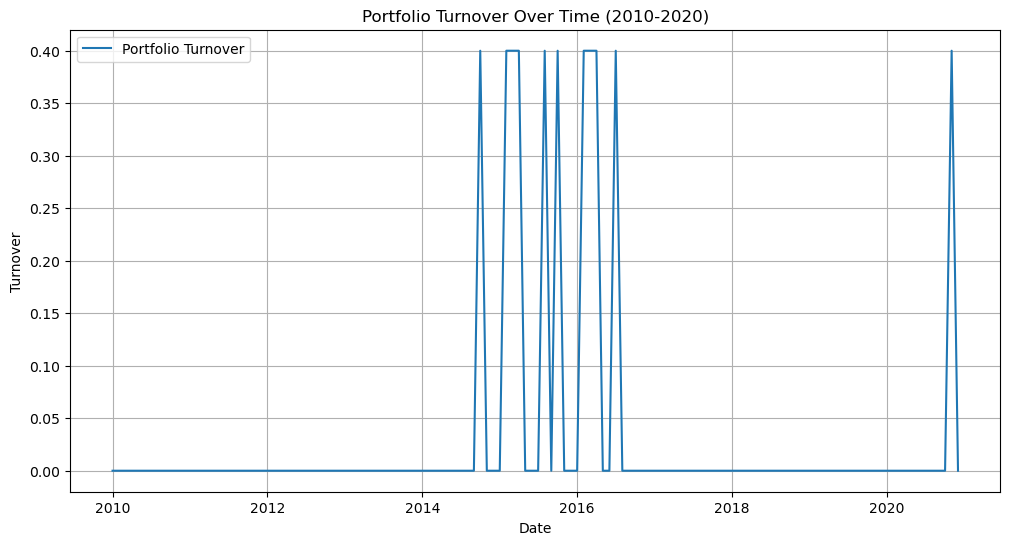

In [190]:
import matplotlib.pyplot as plt

# Initialize variables for turnover calculation
prev_top_5 = set()
turnover_data = []

# Calculate turnover
for (year, month), group in grouped:
    # Sort by market cap in descending order and select the top 5 companies
    top_5 = group.sort_values(by='market_cap', ascending=False).head(5)
    current_top_5 = set(top_5['gvkey'])
    
    # Calculate turnover: fraction of companies that are replaced
    if prev_top_5:
        turnover = len(current_top_5.symmetric_difference(prev_top_5)) / len(prev_top_5)
    else:
        turnover = 0  # No turnover for the first month
    
    turnover_data.append({'year': year, 'month': month, 'turnover': turnover})
    prev_top_5 = current_top_5

# Convert turnover data to a DataFrame
turnover_df = pd.DataFrame(turnover_data)

# Sort by year and month
turnover_df = turnover_df.sort_values(by=['year', 'month']).reset_index(drop=True)

# Create a date column for plotting
turnover_df['date'] = pd.to_datetime(turnover_df[['year', 'month']].assign(day=1))

# Plot turnover over time
plt.figure(figsize=(12, 6))
plt.plot(turnover_df['date'], turnover_df['turnover'], label='Portfolio Turnover')
plt.title('Portfolio Turnover Over Time (2010-2020)')
plt.xlabel('Date')
plt.ylabel('Turnover')
plt.legend()
plt.grid(True)
plt.show()


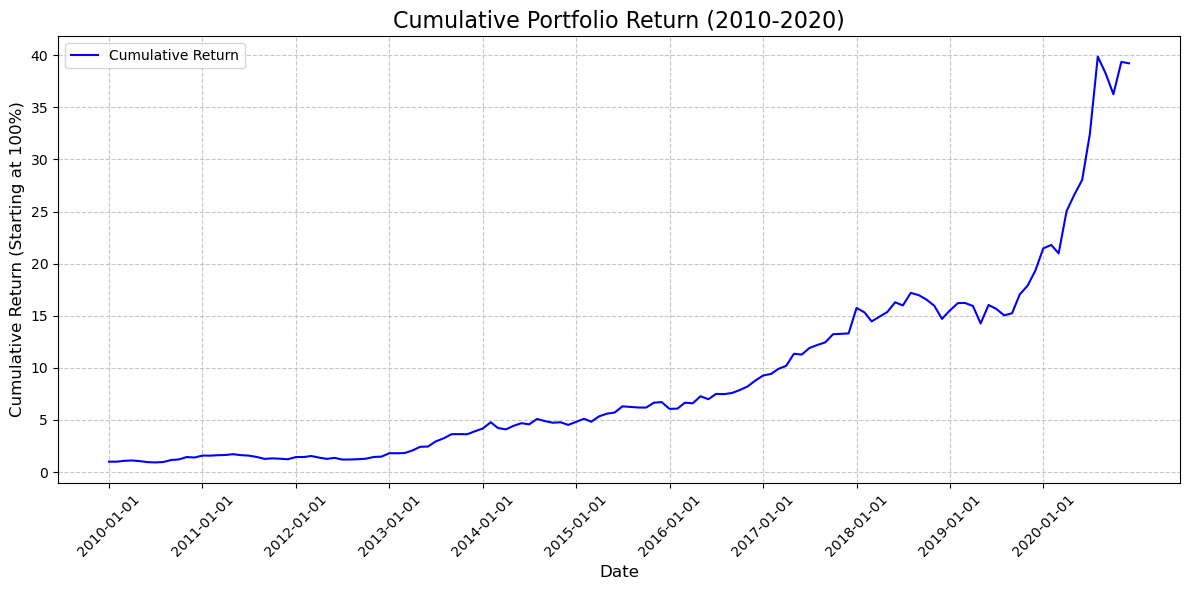

In [191]:
import matplotlib.pyplot as plt
import numpy as np

# Exclude the first month (January 2010) from cumulative return calculations
portfolio_returns_df.loc[portfolio_returns_df.index[0], 'portfolio_return'] = 0  # No return in January

# Start cumulative returns with 1.0 (100%) at the beginning
portfolio_returns_df['cumulative_return'] = (1 + portfolio_returns_df['portfolio_return']).cumprod()

# Create a proper date column for x-axis
portfolio_returns_df['date'] = pd.to_datetime(portfolio_returns_df['year'].astype(str) + '-' + portfolio_returns_df['month'].astype(str) + '-01')

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(portfolio_returns_df['date'], portfolio_returns_df['cumulative_return'], label='Cumulative Return', color='blue')

# Fix title and labels
plt.title('Cumulative Portfolio Return (2010-2020)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return (Starting at 100%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Format x-axis ticks for better readability
plt.xticks(portfolio_returns_df['date'][::12], rotation=45)  # Show one tick per year

# Add y-axis ticks at every integer value
y_min = int(portfolio_returns_df['cumulative_return'].min())
y_max = int(portfolio_returns_df['cumulative_return'].max()) + 1

#plt.yticks(np.arange(y_min, y_max, step=1))

# Show the plot
plt.tight_layout()
plt.show()


## Cash Hedged Portfolio

In [192]:
import pandas as pd

# Assuming `data` contains the necessary data
# Ensure 'date' column is datetime type
data['date'] = pd.to_datetime(data['date'])

# Filter data for the required period (January 2010 to December 2020)
start_date = '2010-01-01'
end_date = '2020-12-31'
filtered_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]

# Add a 'month' and 'year' column for monthly grouping
filtered_data['year'] = filtered_data['date'].dt.year
filtered_data['month'] = filtered_data['date'].dt.month

# Dictionary to store portfolio returns
portfolio_returns = []

# Group data by year and month
grouped = filtered_data.groupby(['year', 'month'])

# Iterate through each month
for (year, month), group in grouped:
    # Sort by market cap in descending order and select the top 5 companies
    top_5 = group.sort_values(by='market_cap', ascending=True).head(5)
    
    # Assign equal weights (20%) to the selected companies
    top_5['weight'] = 0.2
    
    # Calculate the portfolio return for the month
    portfolio_return = (top_5['weight'] * top_5['cash_hedged_return']).sum()
    
    # Store the result
    portfolio_returns.append({
        'year': year,
        'month': month,
        'portfolio_return': portfolio_return
    })

# Convert portfolio returns to a DataFrame
portfolio_returns_df = pd.DataFrame(portfolio_returns)

# Sort by year and month
portfolio_returns_df = portfolio_returns_df.sort_values(by=['year', 'month']).reset_index(drop=True)

# Display portfolio returns
print(portfolio_returns_df.head(50))

# Optionally, save to CSV
# portfolio_returns_df.to_csv("monthly_portfolio_returns_2010_2020.csv", index=False)


    year  month  portfolio_return
0   2010      1         -0.039858
1   2010      2         -0.010356
2   2010      3          0.132840
3   2010      4          0.048071
4   2010      5         -0.073886
5   2010      6         -0.143638
6   2010      7         -0.008173
7   2010      8          0.064818
8   2010      9          0.171184
9   2010     10          0.061220
10  2010     11          0.282579
11  2010     12         -0.359438
12  2011      1          0.154202
13  2011      2         -0.007227
14  2011      3          0.038859
15  2011      4          0.015219
16  2011      5          0.065863
17  2011      6         -0.516195
18  2011      7         -0.034867
19  2011      8         -0.151626
20  2011      9         -0.185951
21  2011     10          0.066124
22  2011     11         -0.018297
23  2011     12         -0.490172
24  2012      1          0.207727
25  2012      2          0.020638
26  2012      3          0.038242
27  2012      4         -0.134169
28  2012      

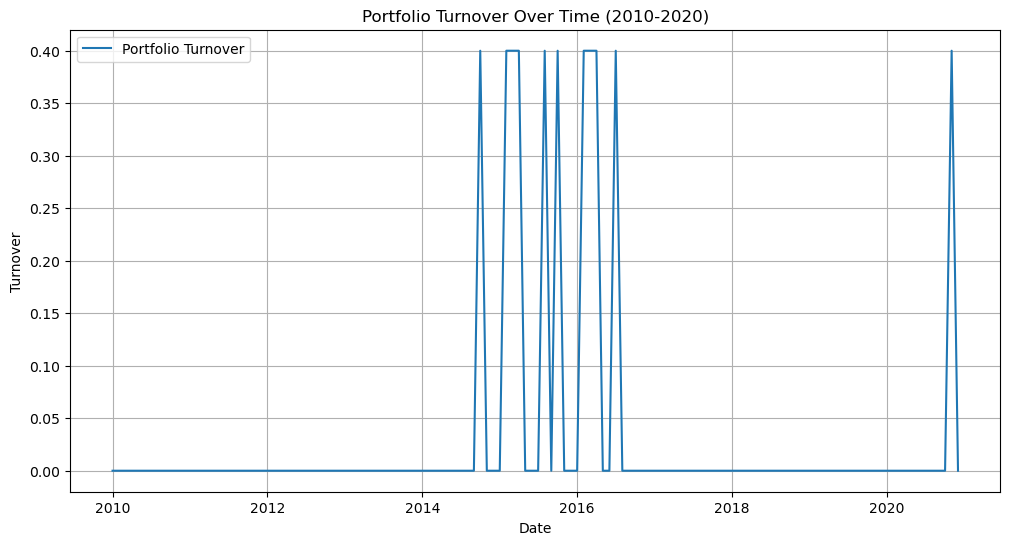

In [193]:
import matplotlib.pyplot as plt

# Initialize variables for turnover calculation
prev_top_5 = set()
turnover_data = []

# Calculate turnover
for (year, month), group in grouped:
    # Sort by market cap in descending order and select the top 5 companies
    top_5 = group.sort_values(by='market_cap', ascending=False).head(5)
    current_top_5 = set(top_5['gvkey'])
    
    # Calculate turnover: fraction of companies that are replaced
    if prev_top_5:
        turnover = len(current_top_5.symmetric_difference(prev_top_5)) / len(prev_top_5)
    else:
        turnover = 0  # No turnover for the first month
    
    turnover_data.append({'year': year, 'month': month, 'turnover': turnover})
    prev_top_5 = current_top_5

# Convert turnover data to a DataFrame
turnover_df = pd.DataFrame(turnover_data)

# Sort by year and month
turnover_df = turnover_df.sort_values(by=['year', 'month']).reset_index(drop=True)

# Create a date column for plotting
turnover_df['date'] = pd.to_datetime(turnover_df[['year', 'month']].assign(day=1))

# Plot turnover over time
plt.figure(figsize=(12, 6))
plt.plot(turnover_df['date'], turnover_df['turnover'], label='Portfolio Turnover')
plt.title('Portfolio Turnover Over Time (2010-2020)')
plt.xlabel('Date')
plt.ylabel('Turnover')
plt.legend()
plt.grid(True)
plt.show()


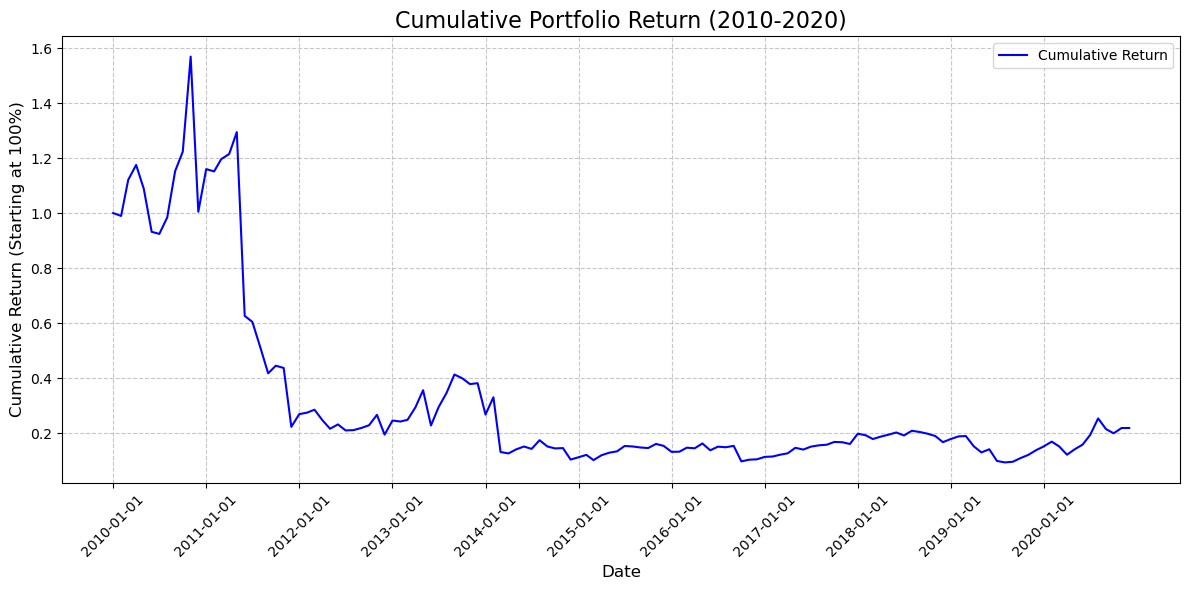

In [194]:
import matplotlib.pyplot as plt

# Exclude the first month (January 2010) from cumulative return calculations
portfolio_returns_df.loc[portfolio_returns_df.index[0], 'portfolio_return'] = 0  # No return in January

# Start cumulative returns with 1.0 (100%) at the beginning
portfolio_returns_df['cumulative_return'] = (1 + portfolio_returns_df['portfolio_return']).cumprod()

# Create a proper date column for x-axis
portfolio_returns_df['date'] = pd.to_datetime(portfolio_returns_df['year'].astype(str) + '-' + portfolio_returns_df['month'].astype(str) + '-01')

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(portfolio_returns_df['date'], portfolio_returns_df['cumulative_return'], label='Cumulative Return', color='blue')

# Fix title and labels
plt.title('Cumulative Portfolio Return (2010-2020)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return (Starting at 100%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Format x-axis ticks for better readability
plt.xticks(portfolio_returns_df['date'][::12], rotation=45)  # Show one tick per year

# Show the plot
plt.tight_layout()
plt.show()


In [195]:
print(portfolio_returns_df.head(10))


   year  month  portfolio_return  cumulative_return       date
0  2010      1          0.000000           1.000000 2010-01-01
1  2010      2         -0.010356           0.989644 2010-02-01
2  2010      3          0.132840           1.121108 2010-03-01
3  2010      4          0.048071           1.175001 2010-04-01
4  2010      5         -0.073886           1.088185 2010-05-01
5  2010      6         -0.143638           0.931880 2010-06-01
6  2010      7         -0.008173           0.924264 2010-07-01
7  2010      8          0.064818           0.984173 2010-08-01
8  2010      9          0.171184           1.152648 2010-09-01
9  2010     10          0.061220           1.223213 2010-10-01
